# Water Ion Product

Determing KW at an arbitrary temperature

In [47]:
#!pip install uncertainties
#!pip install lmfit

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import linregress
from scipy.optimize import curve_fit

import uncertainties as un               # tool set for handling uncertainties
from uncertainties import unumpy as unp  # a replacement for numpy 

!mkdir plots

################################################################################
### Set global variables. Set flag accordingly
################################################################################

#github = True  
github = False  

if github:
    data_path = "https://raw.githubusercontent.com/blinkletter/4410PythonNotebooks/main/Class_10/data/"
    image_path = "https://raw.githubusercontent.com/blinkletter/4410PythonNotebooks/main/Class_10/images/"
    github_data_location = "https://raw.githubusercontent.com/blinkletter/LFER-QSAR/main/data/"
    github_styles_location = "https://raw.githubusercontent.com/blinkletter/LFER-QSAR/main/styles/"
else:
    data_path = "../Class_10/data/"
    image_path = "../Class_10/images/"
    github_data_location = "/Users/blink/github/LFER-QSAR/data/"
    github_styles_location = "/Users/blink/github/LFER-QSAR/styles/"



mkdir: plots: File exists


## Using the Empirical Equation

Using the empirical equation from Marshall \& Franck, 1981, we can calculate values of $K_W$.

## calculation Kw at 17 degrees

The reactions above were performed at $17\ ^\circ C$. What is the value of $K_W$ at $17\ ^\circ C$? A whitepaper on the NIST website presents an empirical formula for claulating the value of KW at temperatures between zero and 100 deg C. We need a data set for the density of water at those temperatures. I found a table on the website of a valve manufacturer in Britain.

log Kw at 17 deg is 50   -13.275119
Name: d g/cm, dtype: float64
log Kw at 17 deg is 50   -13.285588
Name: d g/cm, dtype: float64


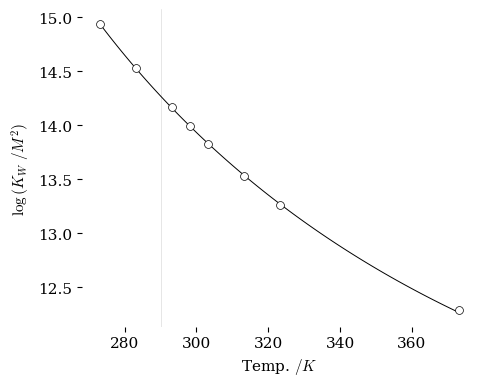

In [48]:
# https://srd.nist.gov/JPCRD/jpcrd181.pdf
# https://www.chemguide.co.uk/physical/acidbaseeqia/kw.html
# 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import linregress
from scipy.optimize import curve_fit


################################################################################
### Read data set. The fields are separated by commas; comments are enabled  ###
################################################################################
df2 = pd.read_csv("data/water_density2.csv",    # dataset from a valve company www.vip-ltd.co.uk
                 delimiter = ",", 
                 skipinitialspace=True, 
#                 index_col="pH", 
                 comment = "#") 
#display(df2.head())


# Data from https://www.chemguide.co.uk/physical/acidbaseeqia/kw.html
Temp = np.array([0,10,20,25,30,40,50,100]) + 273.15 

Kw = np.array([0.114e-14,
               0.293E-14,
               0.681E-14,
               1.008E-14,
               1.471E-14,
               2.916E-14,
               5.476E-14,
               51.30E-14,
           ])

# Empirical equation from https://srd.nist.gov/JPCRD/jpcrd181.pdf
A = -4.098
B = -3245.2
C = 2.2362E5
D = -3.984E7
E = 13.957
F = -1262.3
G = 8.5641E5

T = df2["temp degC"]+273
pw = df2["d g/cm"]/1000

logKwCalcNIST = A + B/T + C/T**2 + D/T**3 + (E + F/T + G/T**2)*np.log10(pw)
pKwCalcNIST = -logKwCalcNIST
logKwCalcNISTnoPressure = A + B/T + C/T**2 + D/T**3 

################################################################################
### Plot the data and the line fit.   
################################################################################
plt.rcdefaults()
plt.style.use(github_styles_location + "tufte.mplstyle")        

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))  


#ax.plot(T, logKwCalcNISTnoPressure, color='black', zorder=1, linestyle = "--", linewidth=0.4)
ax.plot(T, pKwCalcNIST, color='black', zorder=1, linewidth=0.7)

ax.scatter(Temp,-np.log10(Kw), 
           marker = "o", s=32, 
           color="white", edgecolor = "black",
           linewidth = 0.5, zorder=3)

ax.set(ylabel=r"$\log{(K_W\ /M^{2})}$", 
       xlabel=r"Temp. $/K$",
#           xlim=[-0.01,0.35],                  
#          ylim=[-1.25,-0.7]
      
      )
ax.axvline(17+273.15, linewidth = 0.4, color = "lightgray", zorder=0)

temp = 50
T=temp+273.15
line = df2.loc[df2["temp degC"]==temp]
pw = line["d g/cm"]/1000

logKwCalcNIST = A + B/T + C/T**2 + D/T**3 + (E + F/T + G/T**2)*np.log10(pw)

KW17 = logKwCalcNIST
print(f"log Kw at 17 deg is {KW17}")

KW17 = 10**-logKwCalcNIST
conversion = (1/pw)**2
KW17 = KW17 * conversion
KW17 = -np.log10(KW17)
print(f"log Kw at 17 deg is {KW17}")




plt.savefig("plots/KW_plot.pdf")
plt.show()

## Using the Empirical Equation

Using the empirical equation from Marshall \& Franck, 1981, we can calculate values of $K_W$.

## calculation Kw at 17 degrees

The reactions above were performed at $17\ ^\circ C$. What is the value of $K_W$ at $17\ ^\circ C$? A whitepaper on the NIST website presents an empirical formula for claulating the value of KW at temperatures between zero and 100 deg C. We need a data set for the density of water at those temperatures. I found a table on the website of a valve manufacturer in Britain.

## Density data from NIST

,Temperature (C),Pressure (atm),Density (g/ml),Volume (ml/g),Internal Energy (kJ/mol),Enthalpy (kJ/mol),Entropy (J/mol*K),Cv (J/mol*K),Cp (J/mol*K),Sound Spd. (m/s),Joule-Thomson (F/atm),Viscosity (uPa*s),Therm. Cond. (W/m*K),Phase
0,1.0,1.0,0.99990,1.0001,0.075258,0.077083,0.27501,75.930,75.954,1407.4,-0.043855,1731.0,0.55818,liquid
1,2.0,1.0,0.99994,1.0001,0.151180,0.153010,0.55146,75.888,75.899,1412.2,-0.043681,1673.5,0.56066,liquid
2,3.0,1.0,0.99997,1.0000,0.227060,0.228880,0.82671,75.845,75.847,1417.0,-0.043511,1619.0,0.56309,liquid
3,4.0,1.0,0.99997,1.0000,0.302880,0.304710,1.10080,75.799,75.799,1421.6,-0.043344,1567.3,0.56547,liquid
4,5.0,1.0,0.99997,1.0000,0.378660,0.380480,1.37370,75.752,75.755,1426.2,-0.043181,1518.2,0.56779,liquid


log Kw at 17 deg is 49   -13.274959
Name: Density (g/ml), dtype: float64
log Kw at 17 deg is 49   -13.28541
Name: Density (g/ml), dtype: float64


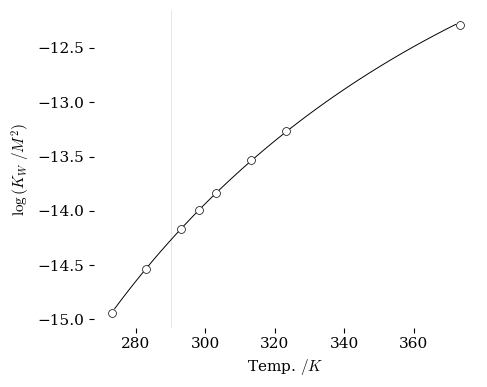

In [49]:
# https://srd.nist.gov/JPCRD/jpcrd181.pdf
# https://www.chemguide.co.uk/physical/acidbaseeqia/kw.html
# 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import linregress
from scipy.optimize import curve_fit


################################################################################
### Read data set. The fields are separated by commas; comments are enabled  ###
################################################################################
df2 = pd.read_csv("data/water_density_NIST_1deg.cgi", 
                 delimiter = "\t", 
                 skipinitialspace=True, 
#                 index_col="pH", 
                 comment = "#") 
display(df2.head())

# Data from https://www.chemguide.co.uk/physical/acidbaseeqia/kw.html
Temp = np.array([0,10,20,25,30,40,50,100]) + 273.15 

Kw = np.array([0.114e-14,
               0.293E-14,
               0.681E-14,
               1.008E-14,
               1.471E-14,
               2.916E-14,
               5.476E-14,
               51.30E-14,
           ])

# Empirical equation from https://srd.nist.gov/JPCRD/jpcrd181.pdf
A = -4.098
B = -3245.2
C = 2.2362E5
D = -3.984E7
E = 13.957
F = -1262.3
G = 8.5641E5

T = df2["Temperature (C)"]+273
pw = df2["Density (g/ml)"]

logKwCalcNIST = A + B/T + C/T**2 + D/T**3 + (E + F/T + G/T**2)*np.log10(pw)
logKwCalcNISTnoPressure = A + B/T + C/T**2 + D/T**3 

################################################################################
### Plot the data and the line fit.   
################################################################################
plt.rcdefaults()
plt.style.use(github_styles_location + "tufte.mplstyle")        

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))  


#ax.plot(T, logKwCalcNISTnoPressure, color='black', zorder=1, linestyle = "--", linewidth=0.4)
ax.plot(T, logKwCalcNIST, color='black', zorder=1, linewidth=0.7)

ax.scatter(Temp,np.log10(Kw), 
           marker = "o", s=32, 
           color="white", edgecolor = "black",
           linewidth = 0.5, zorder=3)

ax.set(ylabel=r"$\log{(K_W\ /M^{2})}$", 
       xlabel=r"Temp. $/K$",
#           xlim=[-0.01,0.35],                  
#          ylim=[-1.25,-0.7]
      
      )
ax.axvline(17+273.15, linewidth = 0.4, color = "lightgray", zorder=0)

temp = 50
T=temp+273.15
line = df2.loc[df2["Temperature (C)"]==temp]
pw = line["Density (g/ml)"]

logKwCalcNIST = A + B/T + C/T**2 + D/T**3 + (E + F/T + G/T**2)*np.log10(pw)

KW17 = logKwCalcNIST
print(f"log Kw at 17 deg is {KW17}")

KW17 = 10**-logKwCalcNIST
conversion = (1/pw)**2
KW17 = KW17 * conversion
KW17 = -np.log10(KW17)
print(f"log Kw at 17 deg is {KW17}")




plt.savefig("plots/KW_plot.pdf")
plt.show()

## Using the Empirical Equation

Using the empirical equation from Marshall \& Franck, 1981, we can calculate values of $K_W$.

## calculation Kw at 17 degrees

The reactions above were performed at $17\ ^\circ C$. What is the value of $K_W$ at $17\ ^\circ C$? A whitepaper on the NIST website presents an empirical formula for claulating the value of KW at temperatures between zero and 100 deg C. We need a data set for the density of water at those temperatures. I found a table on the website of a valve manufacturer in Britain.

## Density data from CRC handbook

,row,temp,density
0,1,0.1,0.999849
1,2,0.2,0.999856
2,3,0.3,0.999862
3,4,0.4,0.999869
4,5,0.5,0.999874


log Kw at 50 deg is 409   -13.274959
Name: density, dtype: float64
log Kw at 50 deg is 409   -13.28541
Name: density, dtype: float64


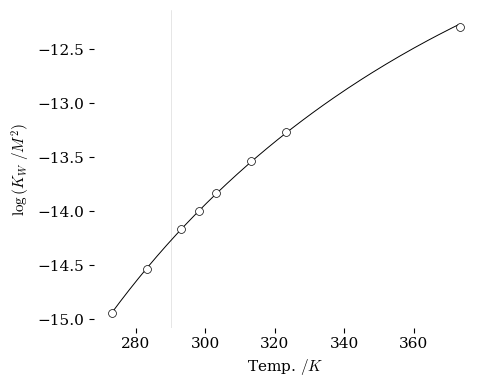

In [50]:
# https://srd.nist.gov/JPCRD/jpcrd181.pdf
# https://www.chemguide.co.uk/physical/acidbaseeqia/kw.html
# 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import linregress
from scipy.optimize import curve_fit


################################################################################
### Read data set. The fields are separated by commas; comments are enabled  ###
################################################################################
df2 = pd.read_csv("data/CRC_Water_Density.txt", 
                 delimiter = "\t", 
                 skipinitialspace=True, 
#                 index_col="pH", 
                 comment = "#") 
display(df2.head())




# Data from https://www.chemguide.co.uk/physical/acidbaseeqia/kw.html
Temp = np.array([0,10,20,25,30,40,50,100]) + 273.15 

Kw = np.array([0.114e-14,
               0.293E-14,
               0.681E-14,
               1.008E-14,
               1.471E-14,
               2.916E-14,
               5.476E-14,
               51.30E-14,
           ])

# Empirical equation from https://srd.nist.gov/JPCRD/jpcrd181.pdf
A = -4.098
B = -3245.2
C = 2.2362E5
D = -3.984E7
E = 13.957
F = -1262.3
G = 8.5641E5

T = df2["temp"]+273
pw = df2["density"]

logKwCalcNIST = A + B/T + C/T**2 + D/T**3 + (E + F/T + G/T**2)*np.log10(pw)
logKwCalcNISTnoPressure = A + B/T + C/T**2 + D/T**3 

################################################################################
### Plot the data and the line fit.   
################################################################################
plt.rcdefaults()
plt.style.use(github_styles_location + "tufte.mplstyle")        

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))  


#ax.plot(T, logKwCalcNISTnoPressure, color='black', zorder=1, linestyle = "--", linewidth=0.4)
ax.plot(T, logKwCalcNIST, color='black', zorder=1, linewidth=0.7)

ax.scatter(Temp,np.log10(Kw), 
           marker = "o", s=32, 
           color="white", edgecolor = "black",
           linewidth = 0.5, zorder=3)

ax.set(ylabel=r"$\log{(K_W\ /M^{2})}$", 
       xlabel=r"Temp. $/K$",
#           xlim=[-0.01,0.35],                  
#          ylim=[-1.25,-0.7]
      
      )
ax.axvline(17+273.15, linewidth = 0.4, color = "lightgray", zorder=0)

temp = 50
T=temp+273.15
line = df2.loc[df2["temp"]==temp]
pw = line["density"]

logKwCalcNISTs = A + B/T + C/T**2 + D/T**3 + (E + F/T + G/T**2)*np.log10(pw)

KW17 = logKwCalcNISTs
print(f"log Kw at {temp} deg is {KW17}")

KW17 = 10**-logKwCalcNISTs
conversion = (1/pw)**2
KW17 = KW17 * conversion
KW17 = -np.log10(KW17)
print(f"log Kw at {temp} deg is {KW17}")




plt.savefig("plots/KW_plot.pdf")
plt.show()

## Using the IAPWS Equation from 2024

Using the empirical equation from IAPWS release of 2024

## Density data from CRC

,row,temp,density
0,1,0.1,0.999849
1,2,0.2,0.999856
2,3,0.3,0.999862
3,4,0.4,0.999869
4,5,0.5,0.999874


log Kw at 25 deg is 249   -13.994365
Name: density, dtype: float64
log Kw at 25 deg is 249   -13.996934
Name: density, dtype: float64


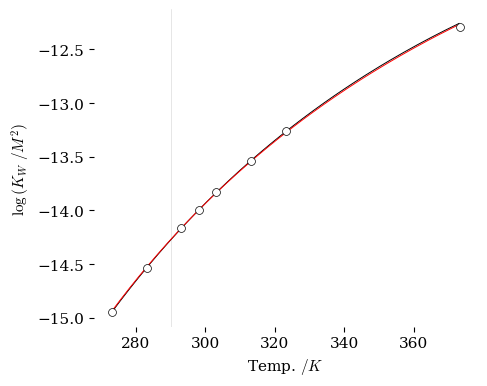

In [51]:
# https://srd.nist.gov/JPCRD/jpcrd181.pdf
# https://www.chemguide.co.uk/physical/acidbaseeqia/kw.html
# 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import linregress
from scipy.optimize import curve_fit


################################################################################
### Read data set. The fields are separated by commas; comments are enabled  ###
################################################################################
df = pd.read_csv("data/CRC_Water_Density.txt", 
                 delimiter = "\t", 
                 skipinitialspace=True, 
#                 index_col="pH", 
                 comment = "#") 
display(df.head())




# Data from https://www.chemguide.co.uk/physical/acidbaseeqia/kw.html
Temp = np.array([0,10,20,25,30,40,50,100]) + 273.15 

Kw = np.array([0.114e-14,
               0.293E-14,
               0.681E-14,
               1.008E-14,
               1.471E-14,
               2.916E-14,
               5.476E-14,
               51.30E-14,
           ])

# Empirical equation from https://srd.nist.gov/JPCRD/jpcrd181.pdf
a0 = -0.702132
a1 = 8681.05
a2 = -24145.1
b0 = 0.813876
b1 = -51.4471
b2 = -0.469920

T = df["temp"]+273
pw = df["density"]

n = 6
mw = 18.015268

pKwG = 0.61416 + 48251.33/T - 67707.93/T**2 + 10102100/T**3
Z = pw * np.exp(a0 + a1/T + a2/T**2 * np.power(pw, (2/3)))
pKwCalcAIPWS = -2*n * (np.log10(1+Z) - Z/(Z+1) * pw * (b0 + b1/T + b2*pw)) + pKwG + 2*np.log10(mw/1000)
logKwCalcAIPWS = -pKwCalcAIPWS

#print(T)
#print(logKwCalcAIPWS)
################################################################################
### Plot the data and the line fit.   
################################################################################
plt.rcdefaults()
plt.style.use(github_styles_location + "tufte.mplstyle")        

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))  

#ax.plot(T, logKwCalcNISTnoPressure, color='black', zorder=1, linestyle = "--", linewidth=0.4)
ax.plot(T, logKwCalcAIPWS, color='black', zorder=1, linewidth=0.7)
ax.plot(T, logKwCalcNIST, color='red', zorder=1, linewidth=0.7)

ax.scatter(Temp,np.log10(Kw), 
           marker = "o", s=32, 
           color="white", edgecolor = "black",
           linewidth = 0.5, zorder=3)

ax.set(ylabel=r"$\log{(K_W\ /M^{2})}$", 
       xlabel=r"Temp. $/K$",
#           xlim=[-0.01,0.35],                  
#          ylim=[-1.25,-0.7]  
      )
ax.axvline(17+273.15, linewidth = 0.4, color = "lightgray", zorder=0)

temp = 25
T=temp+273.15
line = df.loc[df2["temp"]==temp]
pw = line["density"]

pKwG = 0.61416 + 48251.33/T - 67707.93/T**2 + 10102100/T**3
Z = pw * np.exp(a0 + a1/T + a2/T**2 * np.power(pw, (2/3)))
pKwCalcAIPWS = -2*n * (np.log10(1+Z) - Z/(Z+1) * pw * (b0 + b1/T + b2*pw)) + pKwG + 2*np.log10(mw/1000)
logKwCalcAIPWS = -pKwCalcAIPWS

KW17 = logKwCalcAIPWS
print(f"log Kw at {temp} deg is {KW17}")

KW17 = 10**-logKwCalcAIPWS
conversion = (1/pw)**2
KW17 = KW17 * conversion
KW17 = -np.log10(KW17)
print(f"log Kw at {temp} deg is {KW17}")




plt.savefig("plots/KW_plot.pdf")
plt.show()

## Process AIPWS experimental database

In [53]:
# https://srd.nist.gov/JPCRD/jpcrd181.pdf
# https://www.chemguide.co.uk/physical/acidbaseeqia/kw.html
# 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import linregress
from scipy.optimize import curve_fit


################################################################################
### Read data set. The fields are separated by commas; comments are enabled  ###
################################################################################
df2 = pd.read_csv("data/IAPWS_Dataset.txt", 
                 delimiter = "\t", 
                 skipinitialspace=True, 
#                 index_col="pH", 
                 comment = "#") 
#display(df2)

# SELECT DATA

df3 = df2.loc[df2["t (°C)"] < 101]
df4 = df3.loc[df3["ρw (g cm-3)"] < 1]


df5 = df4.sort_values(by=['t (°C)'])
display(df5)
df5.to_csv("data/IAPWS_processed.csv")

# Then hand editted to remove values where density was different than the density table indicating the experiment was performed at a non-standard pressure.

,Source,t (°C),ρw (g cm-3),pKw(exp.),u[pKw(exp.)],pKw(fit),ΔpKw,Diff.
0,Noyes et al. (1910)16,0.0,0.9998,15.050,0.100,14.947,0.104,-0.004
199,Sweeton et al. (1974)1,0.0,0.9998,14.941,0.009,14.947,-0.006,0.003
212,Busey and Mesmer (1978)54,0.0,0.9998,14.941,0.009,14.947,-0.006,0.003
90,Harned and Robinson (1940)49,0.0,0.9998,14.944,0.001,14.947,-0.003,-0.002
277,Chen et al. (1994)62,0.0,0.9998,14.946,0.005,14.947,-0.001,0.004
...,...,...,...,...,...,...,...,...
68,Fisher and Barnes (1972)19,100.0,0.9583,12.193,0.200,12.254,-0.061,0.139
243,Kryukov et al. (1980)55,100.0,0.9998,11.938,0.040,11.937,0.001,0.039
216,Busey and Mesmer (1978)54,100.0,0.9583,12.264,0.009,12.254,0.010,-0.001
273,Ackermann (1958)61,100.0,0.9583,12.259,0.005,12.254,0.005,0.000


## Compare literature data with model

In [43]:
df2 = pd.read_csv("data/IAPWS_edited.csv", 
                 delimiter = ",", 
                 skipinitialspace=True, 
#                 index_col="pH", 
                 comment = "#") 
display(df2)


,Unnamed: 0,Source,t (°C),ρw (g cm-3),pKw(exp.),u[pKw(exp.)],pKw(fit),ΔpKw,Diff.
0,0,Noyes et al. (1910)16,0.0,0.9998,15.050,0.100,14.947,0.104,-0.004
1,199,Sweeton et al. (1974)1,0.0,0.9998,14.941,0.009,14.947,-0.006,0.003
2,212,Busey and Mesmer (1978)54,0.0,0.9998,14.941,0.009,14.947,-0.006,0.003
3,90,Harned and Robinson (1940)49,0.0,0.9998,14.944,0.001,14.947,-0.003,-0.002
4,277,Chen et al. (1994)62,0.0,0.9998,14.946,0.005,14.947,-0.001,0.004
...,...,...,...,...,...,...,...,...,...
58,194,MacDonald et al. (1973)53,100.0,0.9583,12.240,0.030,12.254,-0.014,0.016
59,258,Palmer and Drummond (1988)56,100.0,0.9583,12.270,0.010,12.254,0.016,-0.006
60,68,Fisher and Barnes (1972)19,100.0,0.9583,12.193,0.200,12.254,-0.061,0.139
61,216,Busey and Mesmer (1978)54,100.0,0.9583,12.264,0.009,12.254,0.010,-0.001
